In [1]:
import pandas as pd
import numpy as np

In [632]:
# full_channel_df = pd.read_json('../luna_crash_dataset/luna/LUNA_FullChannel_GDAX_20220511_17hr.json', lines=True)

In [151]:
ticker_df = pd.read_json('../luna_crash_dataset/luna/LUNA_Ticker_GDAX_20220511_17hr.json', lines=True)

In [152]:
# full_channel_df.time = pd.to_datetime(full_channel_df.time)
# full_channel_df['timestamp'] = full_channel_df['time'].astype('int64')

ticker_df.time = pd.to_datetime(ticker_df.time)
ticker_df['timestamp'] = ticker_df['time'].astype('int64')

In [153]:
ticker_df.sort_values(by='sequence', inplace=True)
left_border = ticker_df.iloc[:-1].sequence.reset_index(drop=True)
right_border = ticker_df.iloc[1:].sequence.reset_index(drop=True)
ticker_df = ticker_df.iloc[:-1].copy()
ticker_df['sequence_start'] = left_border
ticker_df['sequence_end'] = right_border

In [363]:
ticker_df['mid_price'] = (ticker_df['best_bid'] + ticker_df['best_ask']) / 2

In [341]:
def find_matching_range(sequence):
    mask = (ticker_df.sequence_start <= sequence) & (sequence < ticker_df.sequence_end)
    if mask.any():
        return ticker_df[mask].sequence.iloc[0]


# full_channel_df['ticker_sequence'] = full_channel_df.sequence.apply(find_matching_range)
full_channel_df = pd.read_csv('full_channel_df_with_ticker_sequence.csv')
full_channel_df.dropna(subset=['ticker_sequence'], inplace=True)
orders_df = full_channel_df.merge(ticker_df.drop(columns=['price', 'timestamp', 'side', 'time', 'type']), left_on='ticker_sequence', right_on='sequence', how='inner')

In [343]:
orders_df.columns

Index(['order_id', 'order_type', 'size', 'price', 'client_oid', 'type', 'side',
       'product_id_x', 'time', 'sequence_x', 'remaining_size', 'trade_id_x',
       'maker_order_id', 'taker_order_id', 'reason', 'funds', 'old_size',
       'new_size', 'timestamp', 'ticker_sequence', 'sequence_y',
       'product_id_y', 'open_24h', 'volume_24h', 'low_24h', 'high_24h',
       'volume_30d', 'best_bid', 'best_ask', 'trade_id_y', 'last_size',
       'sequence_start', 'sequence_end', 'mid_price'],
      dtype='object')

In [344]:
from concurrent.futures import ProcessPoolExecutor


canceled_df = orders_df[orders_df.reason == 'canceled'].copy()


CONCURRENCY = 8
BATCH_SIZE = 1000


orders_received_df = orders_df[orders_df.type == 'received']
def add_size_to_canceled(row):
    if row.reason != 'canceled':
        return None
    mask = (orders_received_df.order_id == row.order_id)
    if mask.any():
        return orders_received_df[mask].iloc[0]['size']


# canceled_df_small = canceled_df.iloc[:10000].copy()
def set_size_to_canceled(canceled_df):
    final_series = None

    with ProcessPoolExecutor(CONCURRENCY) as executor:
        for canceld_df_batch_idx in range(0, canceled_df.shape[0], BATCH_SIZE):
            print('Processing batch ', canceld_df_batch_idx, ' to ', canceld_df_batch_idx + BATCH_SIZE)
            futures = []
            canceled_df_batch = canceled_df.iloc[canceld_df_batch_idx:canceld_df_batch_idx + BATCH_SIZE]
            for i in range(0, canceled_df_batch.shape[0], canceled_df_batch.shape[0] // CONCURRENCY):
                sample = canceled_df_batch.iloc[i:i + canceled_df_batch.shape[0] // CONCURRENCY].copy()
                print('Submitting task of sample ', i, ' to ', i + canceled_df_batch.shape[0] // CONCURRENCY)
                future = executor.submit(sample.apply, add_size_to_canceled, axis=1)
                futures.append(future)
            for future in futures:
                if final_series is None:
                    final_series = future.result()
                else:
                    final_series = pd.concat([final_series, future.result()])

    return final_series


# size = set_size_to_canceled(canceled_df)
# canceled_df['size'] = size
# canceled_df.to_csv('canceled_df_with_size.csv', index=False)

canceled_df = pd.read_csv('canceled_df_with_size.csv')

canceled_mask = (orders_df.reason == 'canceled') & orders_df.order_id.isin(canceled_df.order_id)
canceled_index = orders_df[canceled_mask].index
canceled_df.index = canceled_index
orders_df.loc[canceled_mask, 'size'] = canceled_df['size']

In [345]:
orders_df[orders_df.reason == 'canceled']['size']

12            NaN
19            NaN
28            NaN
35            NaN
45        127.757
           ...   
752525    341.318
752539    118.866
752542     10.000
752548     10.000
752581     10.000
Name: size, Length: 205107, dtype: float64

In [346]:
buy_nan_size_mask = (orders_df.order_type == 'market') & orders_df['size'].isna() & (orders_df.side == 'buy')
orders_df.loc[buy_nan_size_mask, 'size'] = orders_df.loc[buy_nan_size_mask, 'funds'] / orders_df.loc[buy_nan_size_mask, 'best_ask']

sell_nan_size_mask = (orders_df.order_type == 'market') & orders_df['size'].isna() & (orders_df.side == 'sell')
orders_df.loc[sell_nan_size_mask, 'size'] = orders_df.loc[sell_nan_size_mask, 'funds'] / orders_df.loc[sell_nan_size_mask, 'best_bid']

orders_df[(orders_df.order_type == 'market') & orders_df['size'].isna()].shape

(0, 34)

In [348]:
orders_df = orders_df[['timestamp', 'price', 'best_bid', 'best_ask', 'mid_price', 'side', 'order_type', 'reason', 'size', 'time']]

## Velocities

### Limit buy
![alt text](limit_buy.png "limit buy")

### Limit sell
![alt text](limit_sell.png "limit sell")

### Limit buy cancel
![alt text](limit_buy_cancel.png "limit buy cancel")

### Limit sell cancel
![alt text](limit_sell_cancel.png "limit sell cancel")


In [349]:
def calculate_buy_velocity(price: float, alpha: float, delta_t_ns: int, bid: float):
    return (price - (bid - alpha)) / delta_t_ns


def calculate_sell_velocity(price: float, alpha: float, delta_t_ns: int, ask: float):
    return (price - (ask + alpha)) / delta_t_ns


def calculate_buy_cancel_velocity(price: float, alpha: float, delta_t_ns: int, bid: float):
    return ((bid - alpha) - price) / delta_t_ns


def calculate_sell_cancel_velocity(price: float, alpha: float, delta_t_ns: int, ask: float):
    return ((ask + alpha) - price) / delta_t_ns


In [365]:
from matplotlib import pyplot as plt


def plot_mid_price(price_df, limit=100):
    price_df = price_df.head(limit)
    plt.figure(figsize=(10, 5))
    plt.plot(price_df.time, price_df.mid_price, label='Mid Price')
    plt.xlabel('Timestamp')
    plt.ylabel('Mid Price')
    plt.title('Mid Price over Time')
    plt.legend()
    plt.show()


def plot_cumulative_momentum(cumulative_momentum):
    plt.figure(figsize=(10, 5))
    plt.plot(cumulative_momentum)
    plt.xlabel('Timestamp')
    plt.ylabel('Cumulative Momentum')
    plt.title('Cumulative Momentum over Time')
    plt.show()


In [351]:
delta_t_ns = 100_000_000
delta_t_sec = delta_t_ns / 1_000_000_000
start_t_ns = full_channel_df.timestamp.min()
end_t_ns = full_channel_df.timestamp.max()

# alpha = (ticker_df.price.max() - ticker_df.price.min()) / 4
alpha = 0.5

In [354]:
import tqdm


def calculate_momentum(orders_df, alpha, delta_t_ns, start_t_ns, end_t_ns):
    accum_df = None

    counter = 0

    cumulative_momentum = []

    for t in tqdm.tqdm(range(start_t_ns, end_t_ns, delta_t_ns)):
        time_mask = orders_df.timestamp.between(t, t + delta_t_ns, inclusive='left')
        active_area_mask = orders_df.price.between(orders_df.best_bid - alpha, orders_df.best_ask + alpha)
        tmp_df = orders_df[time_mask & active_area_mask].copy()
        tmp_df['velocity'] = np.nan
        tmp_df['momentum'] = np.nan

        buy_mask = (tmp_df.order_type == 'limit') & (tmp_df.side == 'buy')
        sell_mask = (tmp_df.order_type == 'limit') & (tmp_df.side == 'sell')
        buy_cancel_mask = (tmp_df.reason == 'canceled') & (tmp_df.side == 'buy')
        sell_cancel_mask = (tmp_df.reason == 'canceled') & (tmp_df.side == 'sell')
        market_buy_mask = (tmp_df.order_type == 'market') & (tmp_df.side == 'buy')
        market_sell_mask = (tmp_df.order_type == 'market') & (tmp_df.side == 'sell')
        
        tmp_df.loc[buy_mask, 'velocity'] = calculate_buy_velocity(
            tmp_df.loc[buy_mask, 'price'],
            alpha,
            delta_t_sec,
            tmp_df.loc[buy_mask, 'best_bid']
        )
        tmp_df.loc[buy_mask, 'momentum'] = tmp_df.loc[buy_mask, 'velocity'] * tmp_df.loc[buy_mask, 'size']

        tmp_df.loc[sell_mask, 'velocity'] = calculate_sell_velocity(
            tmp_df.loc[sell_mask, 'price'],
            alpha,
            delta_t_sec,
            tmp_df.loc[sell_mask, 'best_ask']
        )
        tmp_df.loc[sell_mask, 'momentum'] = tmp_df.loc[sell_mask, 'velocity'] * tmp_df.loc[sell_mask, 'size']

        tmp_df.loc[buy_cancel_mask, 'velocity'] = calculate_buy_cancel_velocity(
            tmp_df.loc[buy_cancel_mask, 'price'],
            alpha,
            delta_t_sec,
            tmp_df.loc[buy_cancel_mask, 'best_bid']
        )
        tmp_df.loc[buy_cancel_mask, 'momentum'] = tmp_df.loc[buy_cancel_mask, 'velocity'] * tmp_df.loc[buy_cancel_mask, 'size']

        tmp_df.loc[sell_cancel_mask, 'velocity'] = calculate_sell_cancel_velocity(
            tmp_df.loc[sell_cancel_mask, 'price'],
            alpha,
            delta_t_sec,
            tmp_df.loc[sell_cancel_mask, 'best_ask']
        )
        tmp_df.loc[sell_cancel_mask, 'momentum'] = tmp_df.loc[sell_cancel_mask, 'velocity'] * tmp_df.loc[sell_cancel_mask, 'size']

        tmp_df.loc[market_buy_mask, 'velocity'] = calculate_buy_velocity(
            tmp_df.loc[market_buy_mask, 'best_ask'],
            alpha,
            delta_t_sec,
            tmp_df.loc[market_buy_mask, 'best_bid']
        )
        tmp_df.loc[market_buy_mask, 'momentum'] = tmp_df.loc[market_buy_mask, 'velocity'] * tmp_df.loc[market_buy_mask, 'size']

        tmp_df.loc[market_sell_mask, 'velocity'] = calculate_sell_velocity(
            tmp_df.loc[market_sell_mask, 'best_bid'],
            alpha,
            delta_t_sec,
            tmp_df.loc[market_sell_mask, 'best_ask']
        )
        tmp_df.loc[market_sell_mask, 'momentum'] = tmp_df.loc[market_sell_mask, 'velocity'] * tmp_df.loc[market_sell_mask, 'size']

        net_momentum = tmp_df.momentum.sum()
        if len(cumulative_momentum) > 0:
            cumulative_momentum.append(net_momentum + cumulative_momentum[-1])
        else:
            cumulative_momentum.append(net_momentum)
        
        if accum_df is None:
            accum_df = tmp_df.copy()
        else:
            accum_df = pd.concat([accum_df, tmp_df])

        # counter += 1
        # if counter > 10000:
        #     break
    return cumulative_momentum, accum_df


# plot_mid_price(acum_df, limit=100000)


In [355]:
from concurrent.futures import ProcessPoolExecutor


CONCURRENCY = 10
timestamp_interval = (end_t_ns - start_t_ns) // CONCURRENCY

with ProcessPoolExecutor(CONCURRENCY) as executor:
    futures = []
    for start_timestamp in range(start_t_ns, end_t_ns, timestamp_interval):
        tmp_df = orders_df[orders_df.timestamp.between(start_timestamp, start_timestamp + timestamp_interval, inclusive='left')]
        future = executor.submit(calculate_momentum, tmp_df, alpha, delta_t_ns, start_timestamp, start_timestamp + timestamp_interval)
        futures.append(future)


cumulative_momentum, accum_df = futures[0].result()
shift = cumulative_momentum[-1]
for future in futures[1:]:
    momentum, df = future.result()
    shifted_array = np.array(momentum) + shift
    cumulative_momentum.extend(shifted_array)
    shift = cumulative_momentum[-1]
    accum_df = pd.concat([accum_df, df])

100%|██████████| 3593/3593 [01:19<00:00, 45.39it/s]


In [356]:
accum_df[accum_df.momentum.notna() & (accum_df.side == 'buy')]['size'].describe()

count    221908.000000
mean        268.840496
std         738.903669
min           0.021000
25%          10.000000
50%          93.621000
75%         366.889000
max       29000.000000
Name: size, dtype: float64

In [357]:
accum_df[accum_df.momentum.notna() & (accum_df.side == 'sell')]['size'].describe()

count    197765.000000
mean        684.238718
std        1456.411920
min           0.021000
25%           7.182000
50%          36.590000
75%         496.587000
max       24587.944000
Name: size, dtype: float64

In [358]:
orders_df.columns

Index(['timestamp', 'price', 'best_bid', 'best_ask', 'mid_price', 'side',
       'order_type', 'reason', 'size', 'time'],
      dtype='object')

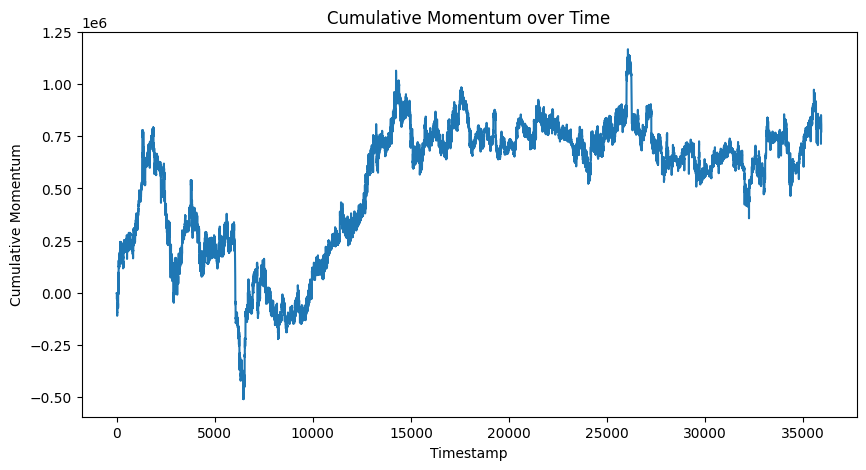

In [366]:
plot_cumulative_momentum(cumulative_momentum)

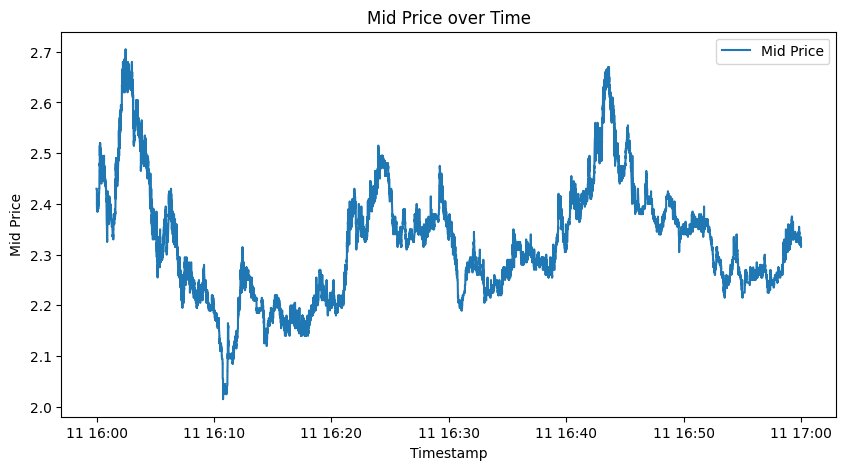

In [364]:
plot_mid_price(ticker_df, limit=100000)

In [ ]:
orders_df[orders_df.order_type == 'limit'].shape

(243751, 38)

In [ ]:
full_channel_df[full_channel_df.sequence >= 1292614427]

,order_id,order_type,size,price,client_oid,type,side,product_id,time,sequence,remaining_size,trade_id,maker_order_id,taker_order_id,reason,funds,old_size,new_size,timestamp
15678,NaN,NaN,11.525,2.42,NaN,match,buy,WLUNA-USD,2022-05-11 15:59:59.959016+00:00,1292614427,NaN,7884870.0,57efb602-15ea-4cd5-baf8-b0a8239ea4b2,355a5570-2884-43bc-9caf-305ed5420435,NaN,NaN,NaN,NaN,1652284799959016000
15679,57efb602-15ea-4cd5-baf8-b0a8239ea4b2,NaN,NaN,2.42,NaN,done,buy,WLUNA-USD,2022-05-11 15:59:59.959016+00:00,1292614428,0.0,NaN,NaN,NaN,filled,NaN,NaN,NaN,1652284799959016000
15680,NaN,NaN,28.646,2.42,NaN,match,buy,WLUNA-USD,2022-05-11 15:59:59.959016+00:00,1292614429,NaN,7884871.0,2670fa8a-ef7c-40d2-98d5-7dbb69172559,355a5570-2884-43bc-9caf-305ed5420435,NaN,NaN,NaN,NaN,1652284799959016000
15681,2670fa8a-ef7c-40d2-98d5-7dbb69172559,NaN,NaN,2.42,NaN,done,buy,WLUNA-USD,2022-05-11 15:59:59.959016+00:00,1292614430,0.0,NaN,NaN,NaN,filled,NaN,NaN,NaN,1652284799959016000
15682,NaN,NaN,14.000,2.42,NaN,match,buy,WLUNA-USD,2022-05-11 15:59:59.959016+00:00,1292614431,NaN,7884872.0,fae9c58b-e1eb-4416-b47c-7e01a0c30e80,355a5570-2884-43bc-9caf-305ed5420435,NaN,NaN,NaN,NaN,1652284799959016000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
768267,22d3c8a0-3942-4315-aa07-a89f2d09f15e,NaN,NaN,2.32,NaN,done,sell,WLUNA-USD,2022-05-11 16:59:52.921821+00:00,1293367016,0.0,NaN,NaN,NaN,filled,NaN,NaN,NaN,1652288392921821000
768268,16efdc4e-f04e-43df-baf4-5ebb76c21285,limit,20.000,2.32,20220511-0000-0000-0004-000000552331,received,sell,WLUNA-USD,2022-05-11 16:59:52.935290+00:00,1293367017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1652288392935290000
768269,NaN,NaN,4.268,2.32,NaN,match,buy,WLUNA-USD,2022-05-11 16:59:52.935290+00:00,1293367018,NaN,7922512.0,17bd2f80-a385-4ad4-b904-94537b6cb3c2,16efdc4e-f04e-43df-baf4-5ebb76c21285,NaN,NaN,NaN,NaN,1652288392935290000
768270,17bd2f80-a385-4ad4-b904-94537b6cb3c2,NaN,NaN,2.32,NaN,done,buy,WLUNA-USD,2022-05-11 16:59:52.935290+00:00,1293367019,0.0,NaN,NaN,NaN,filled,NaN,NaN,NaN,1652288392935290000


In [ ]:
full_channel_df[full_channel_df.order_type == 'limit'].shape

(248796, 19)

In [ ]:
orders_df[orders_df.order_type == 'limit'].shape

(30540, 34)

In [311]:
accum_df[accum_df.momentum.isna() & (accum_df.reason == 'filled')].shape

(191727, 12)

In [193]:
accum_df.velocity.notna().sum()

np.int64(29836)

In [28]:
full_channel_df.order_type.unique()

array(['limit', nan, 'market'], dtype=object)

In [ ]:
full_channel_df.type.unique()

array(['received', 'open', 'match', 'done', 'change'], dtype=object)

In [30]:
full_channel_df.reason.unique()

array([nan, 'filled', 'canceled'], dtype=object)

In [ ]:
ndf = full_channel_df.where(full_channel_df.order_type.isna())

In [46]:
full_channel_df[full_channel_df.order_type == 'market'].shape

(2360, 19)

In [ ]:
full_channel_df[full_channel_df.order_type == 'market'].shape

(2360, 19)

In [ ]:
full_channel_df[full_channel_df.type == 'match']

,order_id,order_type,size,price,client_oid,type,side,product_id,time,sequence,remaining_size,trade_id,maker_order_id,taker_order_id,reason,funds,old_size,new_size,timestamp
5,NaN,NaN,14.000,2.33,NaN,match,buy,WLUNA-USD,2022-05-11 15:59:00.813739+00:00,1292598754,NaN,7884081.0,811f8a8f-53dc-4b0b-b106-9f6cba1eef4b,0299ed2d-d33d-4313-a1d4-b74ce9cc9f26,NaN,NaN,NaN,NaN,1652284740813739000
3,NaN,NaN,374.806,2.33,NaN,match,buy,WLUNA-USD,2022-05-11 15:59:00.813739+00:00,1292598752,NaN,7884080.0,474813db-2329-4aba-a07b-b1adea78da8f,0299ed2d-d33d-4313-a1d4-b74ce9cc9f26,NaN,NaN,NaN,NaN,1652284740813739000
171,NaN,NaN,14.000,2.33,NaN,match,buy,WLUNA-USD,2022-05-11 15:59:01.357997+00:00,1292598920,NaN,7884082.0,df4ec280-7d72-4f13-a79f-4f09bfeed96f,46fd14be-872e-4125-a5d2-b808f16e84b6,NaN,NaN,NaN,NaN,1652284741357997000
367,NaN,NaN,17.473,2.32,NaN,match,buy,WLUNA-USD,2022-05-11 15:59:02.177983+00:00,1292599116,NaN,7884083.0,b1eb85bc-b2ef-40bf-b606-2d57c34b360b,d3126119-1c84-417e-826b-f24329f651a8,NaN,NaN,NaN,NaN,1652284742177983000
369,NaN,NaN,11.525,2.32,NaN,match,buy,WLUNA-USD,2022-05-11 15:59:02.177983+00:00,1292599118,NaN,7884084.0,bb2fde8a-e60c-41eb-853d-65d788a2583b,d3126119-1c84-417e-826b-f24329f651a8,NaN,NaN,NaN,NaN,1652284742177983000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
768261,NaN,NaN,0.428,2.33,NaN,match,sell,WLUNA-USD,2022-05-11 16:59:52.913315+00:00,1293367010,NaN,7922509.0,bd093610-4dd4-419c-9d2e-208ae2a465bf,cfbef5ba-ea97-4007-b79d-3209d85573ba,NaN,NaN,NaN,NaN,1652288392913315000
768264,NaN,NaN,13.771,2.32,NaN,match,buy,WLUNA-USD,2022-05-11 16:59:52.921821+00:00,1293367013,NaN,7922510.0,76b22ba0-975e-4efa-be94-bf71ea5464ae,22d3c8a0-3942-4315-aa07-a89f2d09f15e,NaN,NaN,NaN,NaN,1652288392921821000
768266,NaN,NaN,6.229,2.32,NaN,match,buy,WLUNA-USD,2022-05-11 16:59:52.921821+00:00,1293367015,NaN,7922511.0,17bd2f80-a385-4ad4-b904-94537b6cb3c2,22d3c8a0-3942-4315-aa07-a89f2d09f15e,NaN,NaN,NaN,NaN,1652288392921821000
768271,NaN,NaN,15.732,2.32,NaN,match,buy,WLUNA-USD,2022-05-11 16:59:52.935290+00:00,1293367020,NaN,7922513.0,6025f56a-f1a6-49a6-9dba-3c4c62af7272,16efdc4e-f04e-43df-baf4-5ebb76c21285,NaN,NaN,NaN,NaN,1652288392935290000


In [262]:
#maker_order_id
#811f8a8f-53dc-4b0b-b106-9f6cba1eef4b
#474813db-2329-4aba-a07b-b1adea78da8f

#taker_order_id
#0299ed2d-d33d-4313-a1d4-b74ce9cc9f26

In [ ]:
full_channel_df[(full_channel_df.order_id == '0299ed2d-d33d-4313-a1d4-b74ce9cc9f26') | (full_channel_df.order_id == '811f8a8f-53dc-4b0b-b106-9f6cba1eef4b') | (full_channel_df.order_id == '474813db-2329-4aba-a07b-b1adea78da8f')]

,order_id,order_type,size,price,client_oid,type,side,product_id,time,sequence,remaining_size,trade_id,maker_order_id,taker_order_id,reason,funds,old_size,new_size,timestamp
6,811f8a8f-53dc-4b0b-b106-9f6cba1eef4b,NaN,NaN,2.33,NaN,done,buy,WLUNA-USD,2022-05-11 15:59:00.813739+00:00,1292598755,0.000,NaN,NaN,NaN,filled,NaN,NaN,NaN,1652284740813739000
2,0299ed2d-d33d-4313-a1d4-b74ce9cc9f26,limit,2324.238,2.33,b1f276a7-e271-4c82-9fa7-a55451507f82,received,sell,WLUNA-USD,2022-05-11 15:59:00.813739+00:00,1292598751,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1652284740813739000
7,0299ed2d-d33d-4313-a1d4-b74ce9cc9f26,NaN,NaN,2.33,NaN,done,sell,WLUNA-USD,2022-05-11 15:59:00.813739+00:00,1292598756,1935.432,NaN,NaN,NaN,canceled,NaN,NaN,NaN,1652284740813739000
4,474813db-2329-4aba-a07b-b1adea78da8f,NaN,NaN,2.33,NaN,done,buy,WLUNA-USD,2022-05-11 15:59:00.813739+00:00,1292598753,0.000,NaN,NaN,NaN,filled,NaN,NaN,NaN,1652284740813739000


When order_type is **NaN**, type can be **open**, **match**, **done**, **change** (order change/trade)  
When order_type is **limit** or **market**, type is **received** (order creation)  

When order_type is **NaN**, reason can be **NaN**, **filled**, **canceled** ()  
When order_type is **limit** or **market**, reason can be **NaN**  

